In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [2]:
rm(list=ls())

In [3]:
#install.packages("gbm")
#install.packages("xgboost")

In [4]:
library(tidyverse)

# Modeling packages
library(caret)
library(gbm)      # Implementacion de al forma clasica de gradient boosting en R
library(xgboost)  # General implementacion para extreme gradient boosting
library(gridExtra)
library(recipes)
library(pdp)
library(vip)



── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loaded gbm 2.1.8


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine

# Load data

In [5]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_logical()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

In [6]:
categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

# Split Dataset

In [7]:
set.seed(42)

index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
retention_train <- data[index_train, ]
retention_test  <- data[-index_train, ]

head(retention_train)

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE


# eXtreme Gradient Boosting XGBoost

## Tuning strategy

La estrategia es similar a la mencionada anteriormente solo que ahora tenemos un par extra de hiper-parámetros que tenemos que tener en cuenta:
* Elige un número alto de iteraciones y prueba el *lr* que mejor resultado te de
* Ajusta los parámetros específicos de los árboles
* Explora las opciones de stochastic GBM
* Si notas diferencias sustanciales entre train y val (usando CV) explora los parámetros de regularización
* Prueba ajusta el *lr* para ver si puedes mejorar el performance

## Prepare data
A diferencia de GBM, XGBoost no es posible definir la clásica fórmula de R, en lugar de ello hay que pasar una matriz con las features y un vector con el target. Adicionalmente solo funciona con valores numéricos por lo que hay que convertir las variables categóricas en numericas (one-hot encoding)

In [8]:
prep_retention2 <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_dummy(all_of(categorical), one_hot=TRUE) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
retention_train_clean2  <-  bake(prep_retention2, retention_train)
retention_test_clean2  <-  bake(prep_retention2, retention_test)

X_train <- as.matrix(retention_train_clean2[setdiff(names(retention_train_clean2), "Revenue")])
Y_train <- retention_train_clean2$Revenue
X_test <- as.matrix(retention_test_clean2[setdiff(names(retention_test_clean2), "Revenue")])
Y_test <- retention_test_clean2$Revenue

## Base model

La forma más simple de usar XGBoost es usando la función `xgboost` y darle algunos parámetros para el entrenamiento y ver como nos da el resultado.

**Parámetros Generales**
* **booster**:
  * `gbtree` Por defecto
  * `gblinear`
* **nthread**: Número de CPU que usará en el entrenamiento
  * Por defecto usa todos los CPU disponibles
 
**Parámetros de booster**
* **eta**: Learning rate / shrinkage.
  * por defecto 0.3
  * valor finales pueden ser cercanos a 0.01-0.2
* **max_depth**: máxima profundidad de cada árbol.
  * por defecto 6
* **min_child_weight**: suma de los pesos de las observaciones en una hoja.
  * Por defecto 1
* **subsample**: muestreo sin reemplazo con el que se entrena cada nuevo árbol.
  * por defecto 1
  * rango de valores entre 0.5 y 1
* **colsample_bytree**: Porcentaje de columnas consideradas para el entrenamiento de cada modelo.
  * por defecto 1
  * rango de valores entre 0.5 y 1
* **colsample_bylevel**: Porcentaje de columnas consideradas en cada split, en general es suficiente con colsample_bytree.
  * por defecto 1
* **scale_pos_weight**: En caso de dataset muy desbalanceados se puede cambiar el peso de las observaciones para ayudar a la convergencia del óptimo.
  * por defecto 0

**Learning Task**
* **objective**:
  * `binary:logistic` logistic regression para problemas de clasificación binaria (sólo probabilidad)
  * `binary:hinge` hinge loss para clasificación binaria. Retorna valores 0 o 1 en lugar de la probabilidad.
* **eval_metric**: [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
  * `logloss`
  * `mlogloss`
  * `error` (threshold = 0.5)
  * `auc`
  * `aucpr`
  * `rmse`
  * `mae`

### Modelo base

[1] "min train error -> 0.024633"

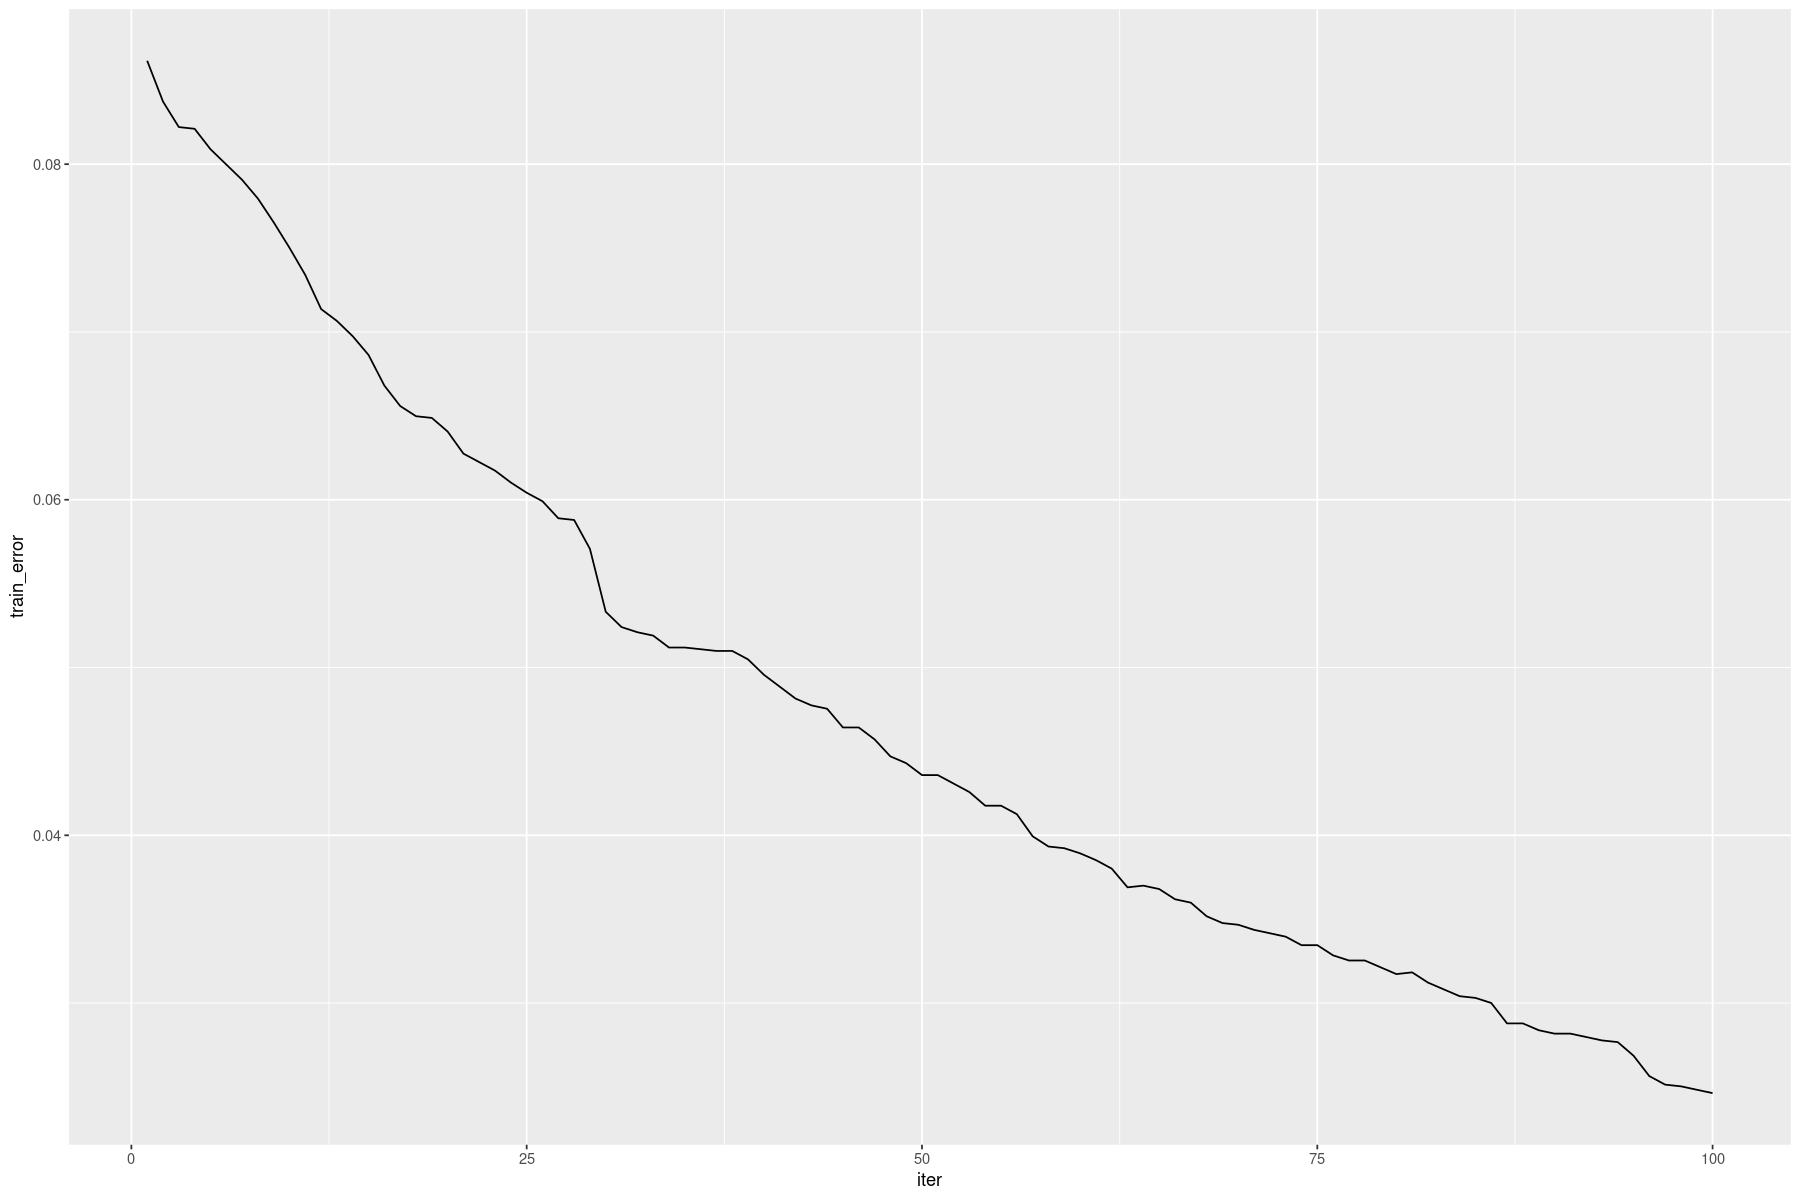

In [9]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1
)

intention_xgb_basic1 <- xgboost(
  params = params,
  data = X_train,
  label = Y_train,
  nrounds = 100,
  verbose = 0
)

paste('min train error ->', min(intention_xgb_basic1$evaluation_log$train_error))

intention_xgb_basic1$evaluation_log %>% 
    ggplot(aes(iter, train_error)) + geom_line()

#### Evaluación train 

In [10]:
data_to_eval = X_train
real_target = Y_train
pred_retention <- predict(intention_xgb_basic1, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8303  208
         1   35 1319
                                          
               Accuracy : 0.9754          
                 95% CI : (0.9721, 0.9783)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9013          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.9742          
                 Recall : 0.8638          
                     F1 : 0.9157          
             Prevalence : 0.1548          
         Detection Rate : 0.1337          
   Detection Prevalence : 0.1373          
      Balanced Accuracy : 0.9298          
                                          
       'Positive' Class : 1               
                                          

#### Evaluación test

In [11]:
data_to_eval = X_test
real_target = Y_test
pred_retention <- predict(intention_xgb_basic1, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1984  160
         1  100  221
                                          
               Accuracy : 0.8945          
                 95% CI : (0.8817, 0.9064)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 9.161e-13       
                                          
                  Kappa : 0.5687          
                                          
 Mcnemar's Test P-Value : 0.0002532       
                                          
              Precision : 0.68847         
                 Recall : 0.58005         
                     F1 : 0.62963         
             Prevalence : 0.15456         
         Detection Rate : 0.08966         
   Detection Prevalence : 0.13022         
      Balanced Accuracy : 0.76603         
                                          
       'Positive' Class : 1               
                                          

## Fine tuning xgboost


### Round 0
Probar el mejor lr con los parametros iniciales.

* **eta** = (0.3, 0.1, 0.01)


In [12]:
# hyperparameter grid
hyper_grid0 <- expand.grid(
  eta = c(0.3, 0.1, 0.01),
  max_depth = 6, 
  min_child_weight = 1,
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid0))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 200,
    objective = "binary:logistic",
    early_stopping_rounds = 20, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid0$eta[i], 
      max_depth = hyper_grid0$max_depth[i],
      min_child_weight = hyper_grid0$min_child_weight[i],
      subsample = hyper_grid0$subsample[i],
      colsample_bytree = hyper_grid0$colsample_bytree[i],
      gamma = hyper_grid0$gamma[i]
    ) 
  )
  hyper_grid0$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid0$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid0$trees[i] <- model$best_iteration
  rm(model)
  gc(verbose=FALSE)
}

# results
hyper_grid0 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.10,6,1,1,1,0,0.0751648,0.0975162,11
2,0.01,6,1,1,1,0,0.0778764,0.0976170,48
3,0.30,6,1,1,1,0,0.0764570,0.0984284,5


### Round 1
Con el lr seleccionado ahora buscamos que parametros son los mejorar para el cada arbol, profundidad del arbol y el numero minimo de observaciones en una hoja

* **max_depth** = (1, 3, 5, 9) 
* **min_child_weight** = (1, 3, 6)

In [13]:
# hyperparameter grid
hyper_grid1 <- expand.grid(
  eta = 0.1,
  max_depth = c(1, 3, 5, 9), 
  min_child_weight = c(1, 3, 6),
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid1))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid1[i,])
  )
  hyper_grid1$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid1$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid1$trees[i] <- model$best_iteration
  rm(model)
  gc(verbose=FALSE)
}

In [14]:
# results
hyper_grid1 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,1,1,0,0.0873036,0.0953874,67
2,0.1,3,1,1,1,0,0.0895084,0.0959954,33
3,0.1,5,1,1,1,0,0.0811710,0.0965022,16
4,0.1,3,3,1,1,0,0.0875824,0.0965024,65
5,0.1,5,3,1,1,0,0.0827674,0.0971110,22
6,0.1,5,6,1,1,0,0.0832490,0.0976174,23


### Round 1.1
Dado que en nuestra busqueda anterior el maximo numero de observaciones fue 6 y la mejor combinación usa este numero podemos explorar valores mas grandes de esta a ver si es ese el mejor o podemos bajar mas el error con un numero mayor

* **min_child_weight** = c(**6**, 8, 10),

In [15]:
# hyperparameter grid
hyper_grid1_1 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = c(6, 8, 10),
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid1_1))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 20, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid1_1[i,])
  )
  hyper_grid1_1$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid1_1$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid1_1$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

hyper_grid1_1 %>%
  arrange(logloss_test) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,1,1,0,0.0939176,0.0967052,11
2,0.1,3,8,1,1,0,0.0938924,0.0967052,11
3,0.1,3,10,1,1,0,0.0901674,0.0970096,31


### Round 2
Ahora que ya tenemos los mejor valores para los arboles podemos explorar los parametros de asociados a aleatoridad como el numero de features con el que se construye cada arbol y el porcentaje de observaciones que se usa para entrenar cada arbol.

* **colsample_bytree** = (0.5, 0.7, 0.9)
* **subsample** = (0.5, 0.7, 0.9)

In [16]:
# hyperparameter grid
hyper_grid2 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = c(0.5, 0.7, 0.9),
  subsample = c(0.5, 0.7, 0.9),
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid2))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 20, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid2[i,])
  )
  hyper_grid2$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid2$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid2$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

hyper_grid2 %>%
  arrange(logloss_test) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"
[1] "iteration  7"
[1] "iteration  8"
[1] "iteration  9"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.9,0.5,0,0.0901166,0.0953880,46
2,0.1,3,6,0.9,0.9,0,0.0884946,0.0956916,48
3,0.1,3,6,0.7,0.9,0,0.0874302,0.0957930,68
4,0.1,3,6,0.5,0.7,0,0.0888240,0.0957932,54
5,0.1,3,6,0.7,0.7,0,0.0882414,0.0963002,51
6,0.1,3,6,0.5,0.9,0,0.0867968,0.0965026,82


### Round 2.1
Dado que el mejor colsample_bytree es 0.9 y fue el maximo en el rango podemos explerimentar con llegar a 1 y ver que pasa, mientras que el numero el sample el mejor fue el menos tambien podemos explorar valores más bajos.

* **subsample** = (0.3, 0.4, 0.5)
* **colsample_bytree** = (0.9, 1)

In [17]:
# hyperparameter grid
hyper_grid2_1 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  subsample = c(0.3, 0.4, 0.5),
  colsample_bytree= c(0.9, 1),
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid2_1))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 20, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid2_1[i,])
  )
  hyper_grid2_1$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid2_1$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid2_1$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

hyper_grid2_1 %>%
  arrange(logloss_test) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"


,eta,max_depth,min_child_weight,subsample,colsample_bytree,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.5,0.9,0,0.0901166,0.0953880,46
2,0.1,3,6,0.4,1.0,0,0.0909022,0.0959956,32
3,0.1,3,6,0.5,1.0,0,0.0894574,0.0963000,44
4,0.1,3,6,0.3,1.0,0,0.0909274,0.0968064,47
5,0.1,3,6,0.4,0.9,0,0.0897872,0.0969080,46
6,0.1,3,6,0.3,0.9,0,0.0914342,0.0974156,44


### Round 3
El paso siguiente es revisar si la regularización nos puede ayudar a reducir más el error. Para ello probaremos con el parametro gamma primero y despues con alpha y lambda.

gamma = (0, 0.1, 0.2, 0.3, 0.4, 0.5)

In [18]:
# hyperparameter grid
hyper_grid3 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.9,
  subsample = 0.5,
  gamma = seq(0, 0.5, 0.1),
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid3))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 20, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid3[i,])
  )
  hyper_grid3$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid3$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid3$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

hyper_grid3 %>%
  arrange(logloss_test) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.9,0.5,0.1,0.0900914,0.0951854,46
2,0.1,3,6,0.9,0.5,0.2,0.0900154,0.0951854,46
3,0.1,3,6,0.9,0.5,0.3,0.0899394,0.0951854,46
4,0.1,3,6,0.9,0.5,0.4,0.0898886,0.0951854,46
5,0.1,3,6,0.9,0.5,0.5,0.0898886,0.0951854,46
6,0.1,3,6,0.9,0.5,0.0,0.0901166,0.0953880,46


### Round 3.1
Acá revisamos si podemos mejorar usando lambda y alpha

In [19]:
hyper_grid3_1 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.9,
  subsample = 0.5,
  gamma = 0.1,
  lambda = c(0, 0.1, 1, 100),
  alpha = c(0, 0.1, 1, 100),
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid3_1))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 20, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid3_1[i,])
  )
  hyper_grid3_1$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid3_1$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid3_1$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

hyper_grid3_1 %>%
  arrange(logloss_test) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"
[1] "iteration  7"
[1] "iteration  8"
[1] "iteration  9"
[1] "iteration  10"
[1] "iteration  11"
[1] "iteration  12"
[1] "iteration  13"
[1] "iteration  14"
[1] "iteration  15"
[1] "iteration  16"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.9,0.5,0.1,0.0,0.0,0.0898884,0.0951854,45
2,0.1,3,6,0.9,0.5,0.1,1.0,0.0,0.0900914,0.0951854,46
3,0.1,3,6,0.9,0.5,0.1,0.0,0.1,0.0891788,0.0953882,49
4,0.1,3,6,0.9,0.5,0.1,0.1,0.1,0.0900912,0.0955910,42
5,0.1,3,6,0.9,0.5,0.1,1.0,0.1,0.0896098,0.0958950,47
6,0.1,3,6,0.9,0.5,0.1,0.1,0.0,0.0894830,0.0960972,49


### Round 4
Despues de todas la pruebas anteriores tomamos la mejor combinación y probamos si al bajar el learning rate mejora el performance.

* **eta** = (0.1, 0.05, 0.01)

In [20]:
# hyperparameter grid
hyper_grid4 <- expand.grid(
  eta = c(0.1, 0.05, 0.01),
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.9,
  subsample = 0.5,
  gamma = 0.1,
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid4))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 300,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = as.list(hyper_grid4[i,])
  )
  hyper_grid4$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid4$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid4$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

hyper_grid4 %>%
  arrange(logloss_test) %>%
  head()

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"


,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.05,3,6,0.9,0.5,0.1,0,0,0.0896098,0.0950830,89
2,0.10,3,6,0.9,0.5,0.1,0,0,0.0898884,0.0951854,45
3,0.01,3,6,0.9,0.5,0.1,0,0,0.0913836,0.0974152,242


### Best Model
Con la mejor configuración de hiper-parámetros y con el learning rate optimo lo unico que nos queda por revisar es cual es el numero optimo de arboles (nround).



#### CV
Entrenamos el model con los mejores parametros y usamos CV para ver cual es el numero de arboles que nos da el menos error en el conjunto de validación

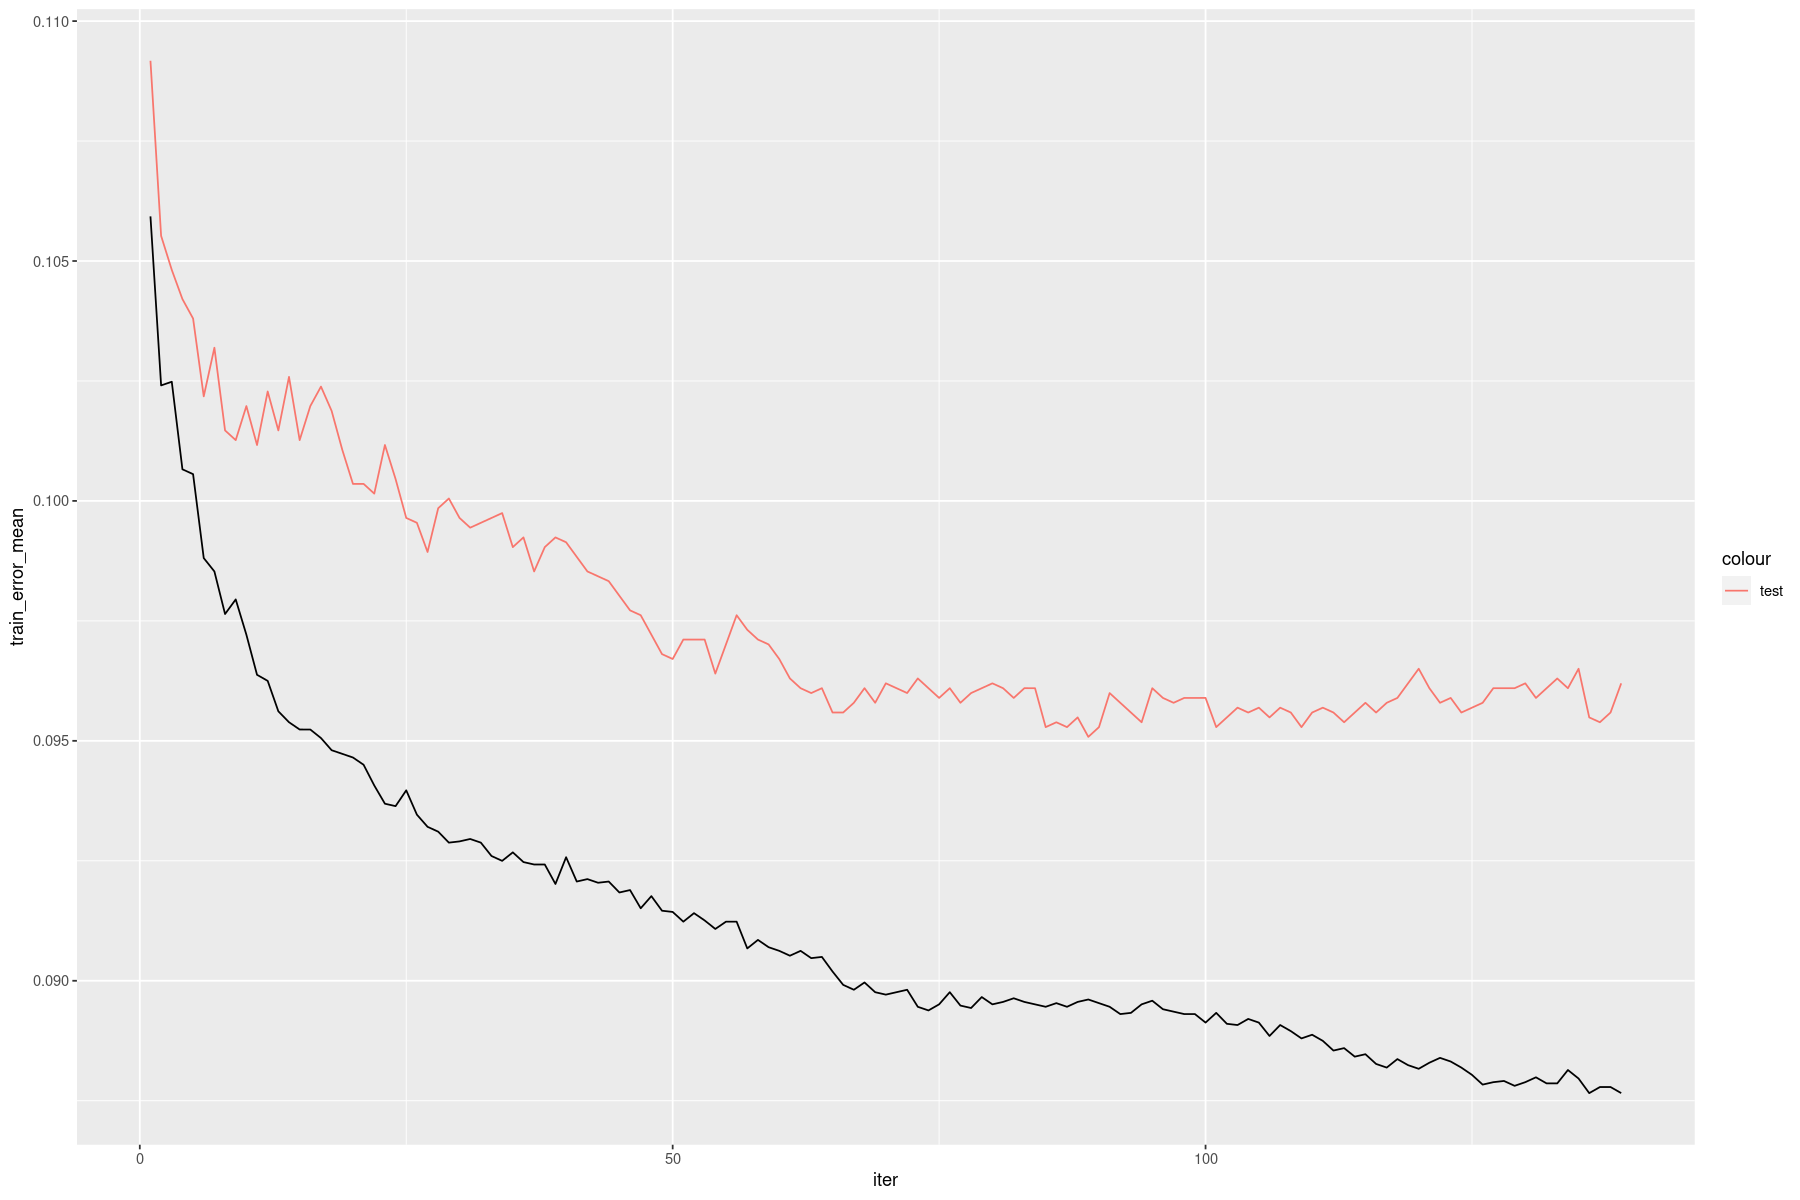

In [21]:
# hyperparameter grid
hyper_best <- list(
  eta = 0.05,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.9,
  subsample = 0.5,
  gamma = 0.1,
  lambda = 0,
  alpha = 0
)

set.seed(42)
best_model_cv <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 300,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = hyper_best
)

best_model_cv$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='test'))

In [22]:
best_model_cv$best_iteration

[1] 89

No se puede usar best_model_cv para hacer predicciones por eso es necesario entrenar el mejor modelo con `xgboost`

#### Best

In [23]:
set.seed(42)
final_model_xgb <- xgboost(
    data = X_train,
    label = Y_train,
    nrounds = 89,
    objective = "binary:logistic",
    verbose = 0,
    params = list(
      eta = 0.05,
      max_depth = 3, 
      min_child_weight = 6,
      colsample_bytree = 0.9,
      subsample = 0.5,
      gamma = 0.1,
      lambda = 0,
      alpha = 0
    )
)

#### Evaluación train

In [24]:
data_to_eval = X_train
real_target = Y_train
pred_retention <- predict(final_model_xgb, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8022  570
         1  316  957
                                          
               Accuracy : 0.9102          
                 95% CI : (0.9044, 0.9158)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6317          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.75177         
                 Recall : 0.62672         
                     F1 : 0.68357         
             Prevalence : 0.15479         
         Detection Rate : 0.09701         
   Detection Prevalence : 0.12904         
      Balanced Accuracy : 0.79441         
                                          
       'Positive' Class : 1               
                                          

#### Evaluación test

In [25]:
data_to_eval = X_test
real_target = Y_test
pred_retention <- predict(final_model_xgb, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1995  147
         1   89  234
                                         
               Accuracy : 0.9043         
                 95% CI : (0.892, 0.9156)
    No Information Rate : 0.8454         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6094         
                                         
 Mcnemar's Test P-Value : 0.0002069      
                                         
              Precision : 0.72446        
                 Recall : 0.61417        
                     F1 : 0.66477        
             Prevalence : 0.15456        
         Detection Rate : 0.09493        
   Detection Prevalence : 0.13103        
      Balanced Accuracy : 0.78573        
                                         
       'Positive' Class : 1              
                                         

#### Feature interpretation

Al igual que RF, GBM implementan impurity para obtener las features que más influyen en la reducción de la loss en la predicción. Sin embargo XGBoost implementa un par mas:

* **Gain**: es el equivalente al usado en RF (impurity)
* **Coverage**: cuantifica el número relativo de observaciones que se usó de una feature para llegar a una hoja.
* **Frequency**: Porcentaje del número de veces que una feature fue usada para hacer un split entre todos los árboles


In [26]:
importance_matrix <- xgb.importance(model=final_model_xgb)

In [27]:
head(importance_matrix)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
PageValues,0.71836965,0.34608581,0.19624573
Month_Nov,0.06299160,0.17754912,0.12116041
ProductRelated_Duration,0.04580896,0.09726922,0.14334471
ExitRates,0.03738909,0.07268959,0.10068259
BounceRates,0.02895077,0.03129584,0.05631399
Administrative_Duration,0.02678640,0.07223888,0.10238908


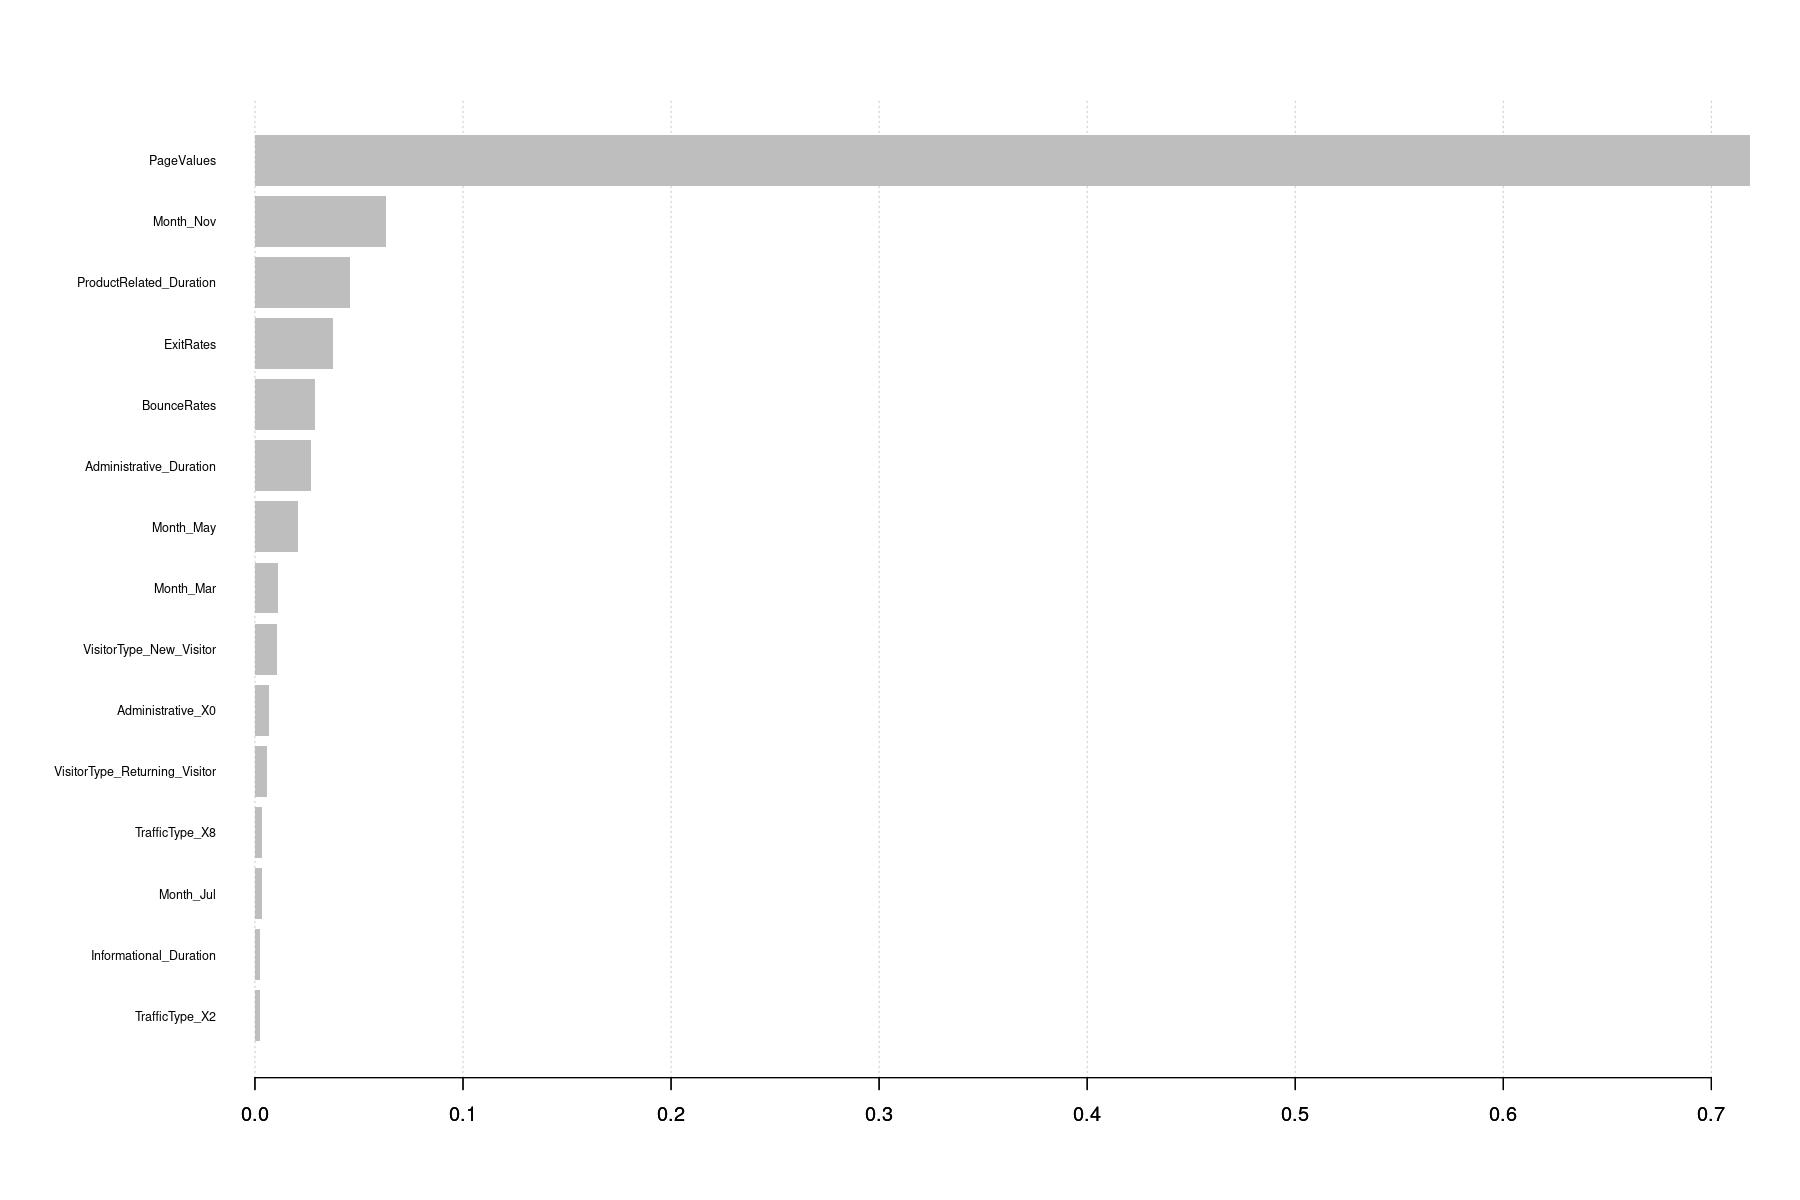

In [28]:
xgb.plot.importance(importance_matrix = importance_matrix, top_n=15)

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


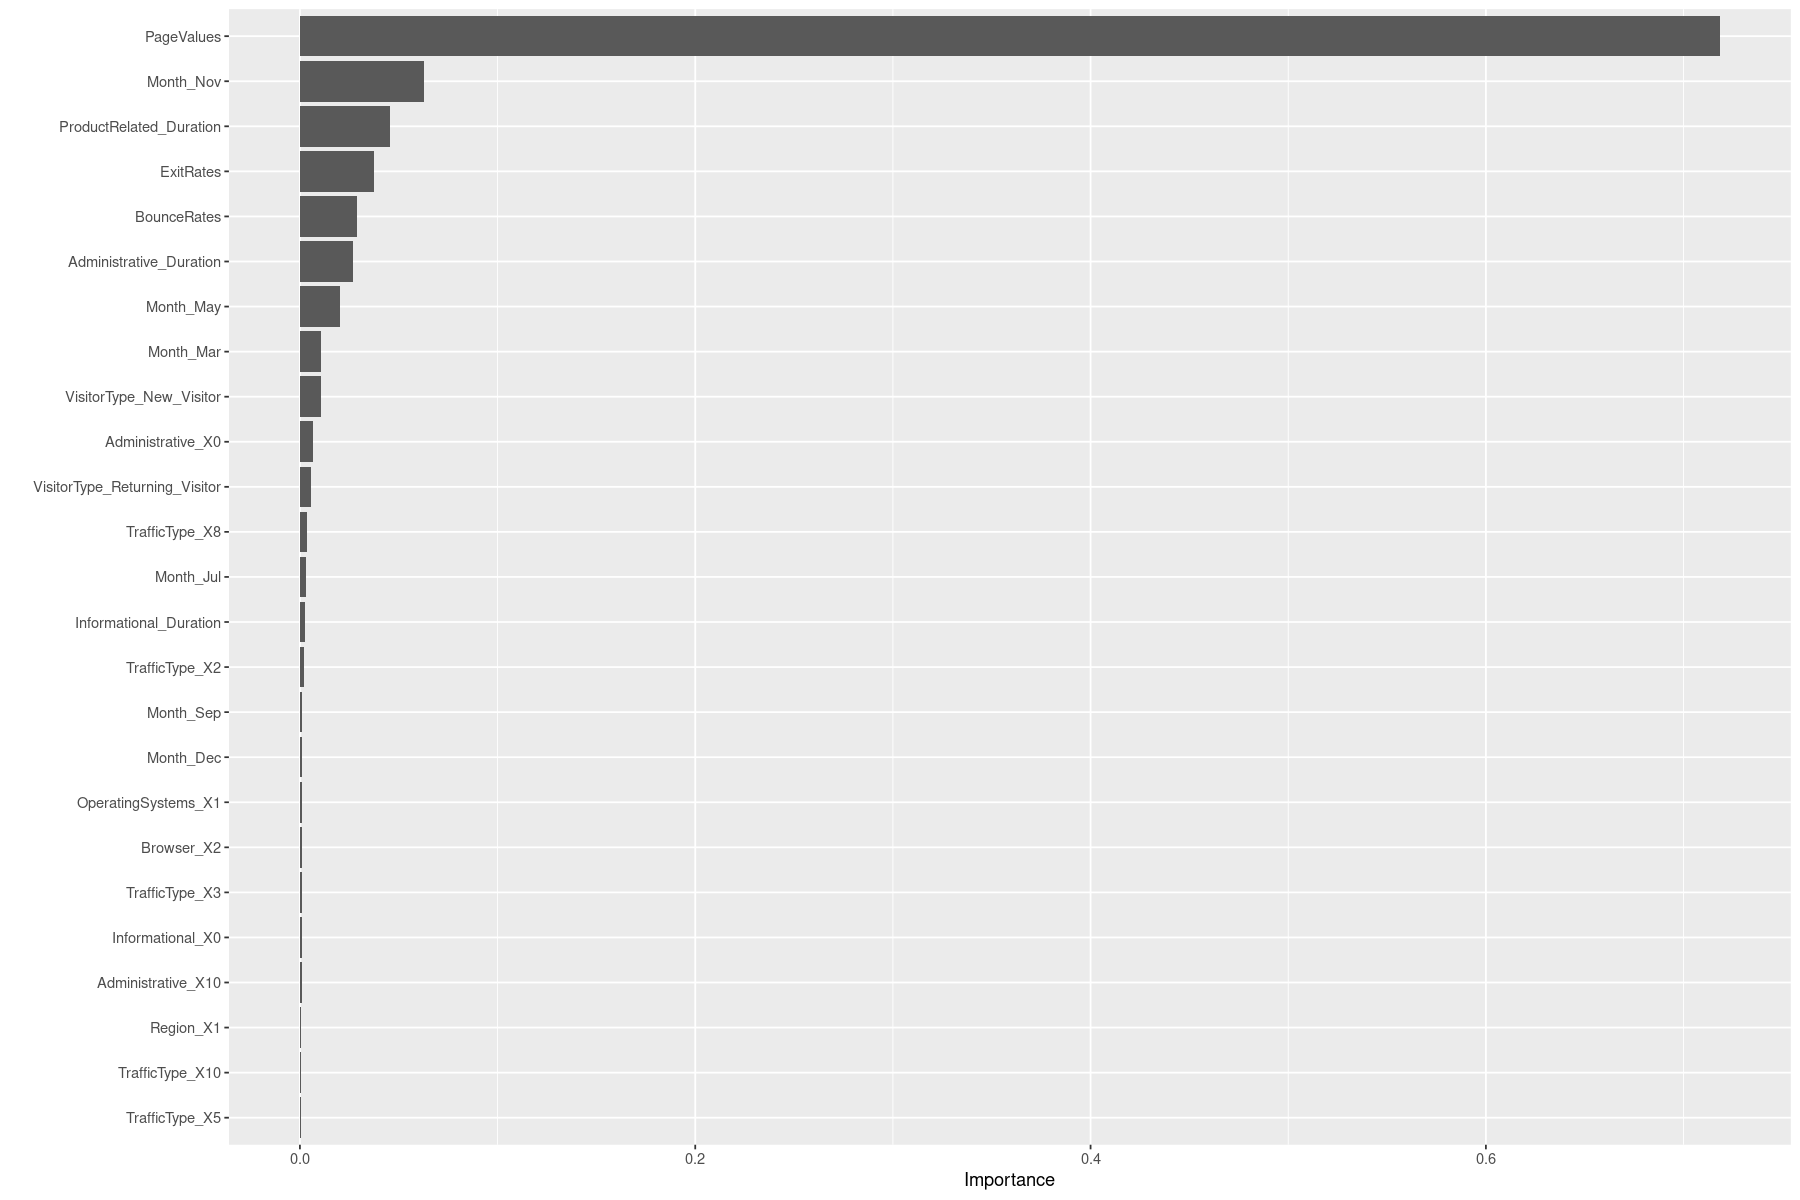

In [29]:
vip::vip(final_model_xgb, type="gain", num_features = 25)

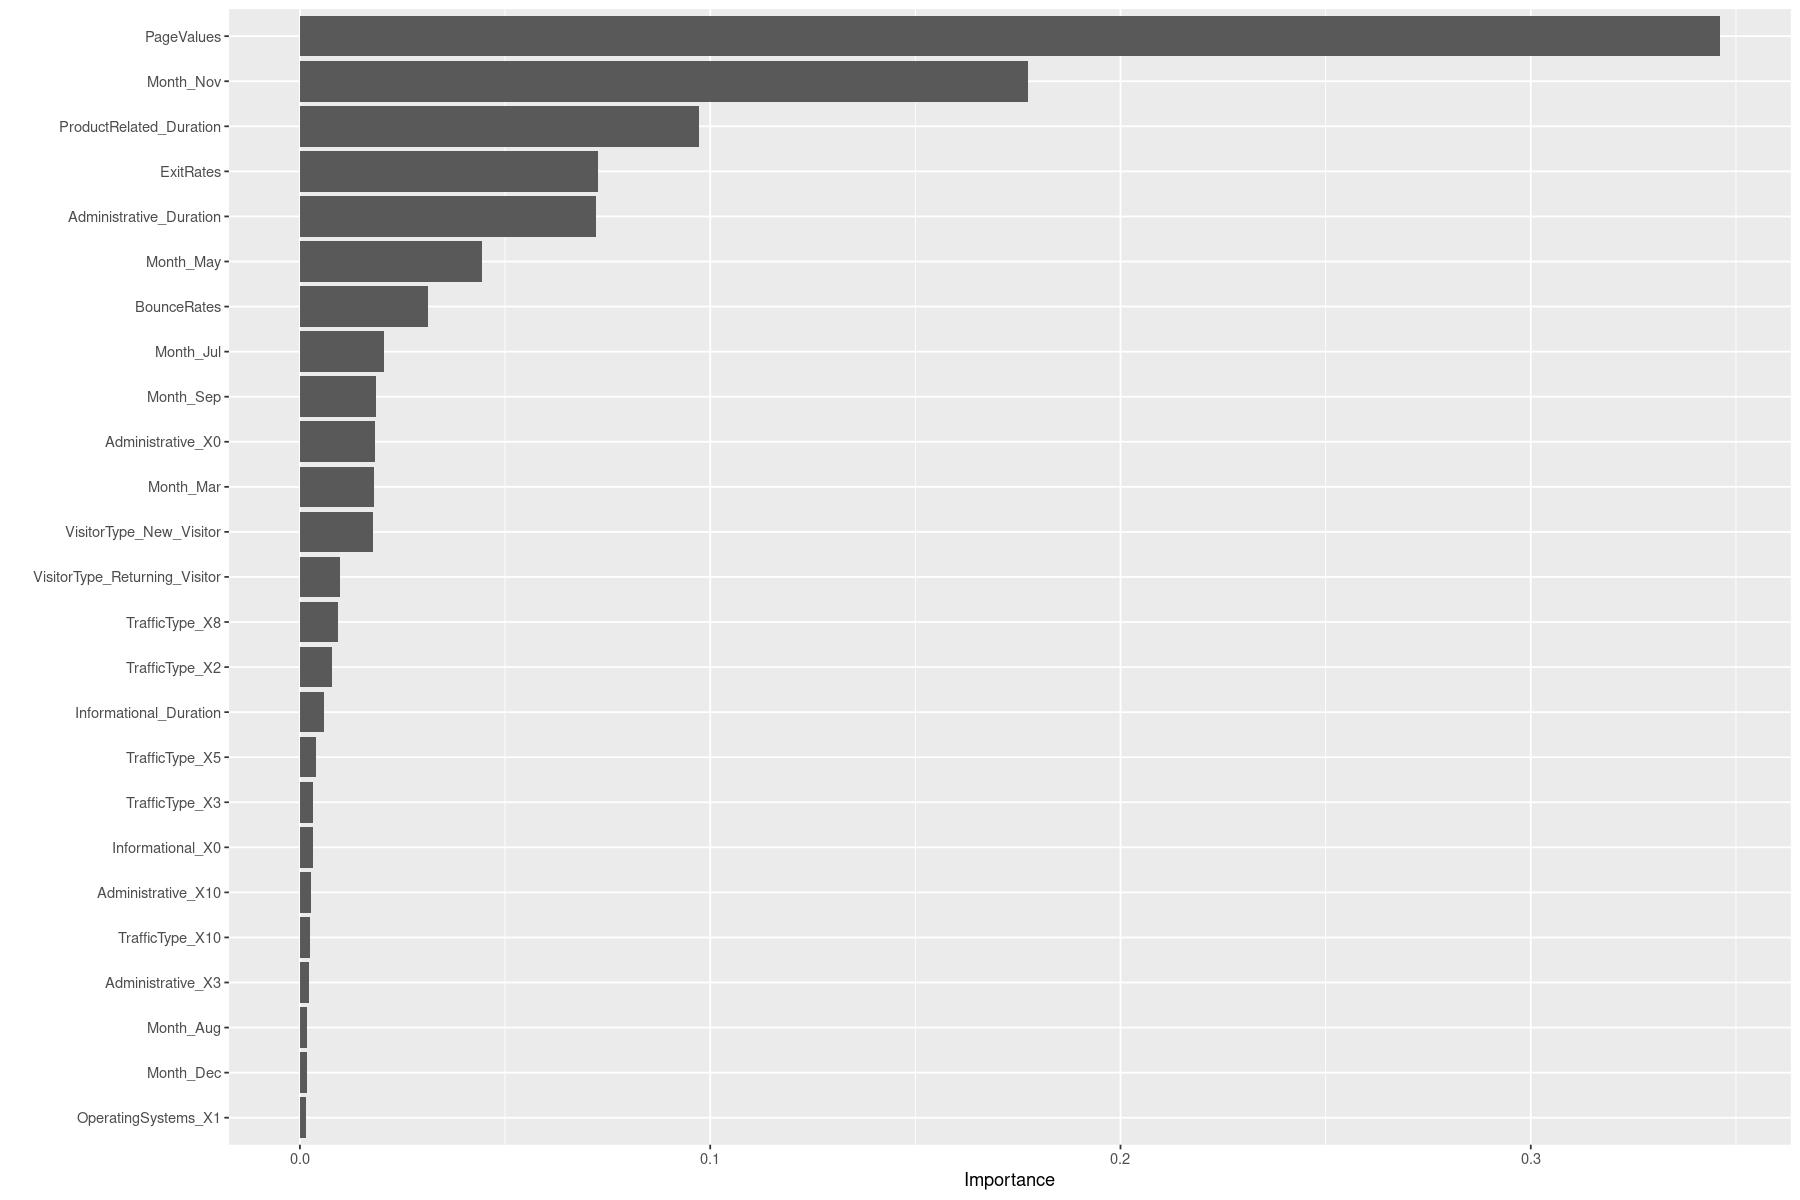

In [30]:
vip::vip(final_model_xgb, type="cover", num_features = 25)

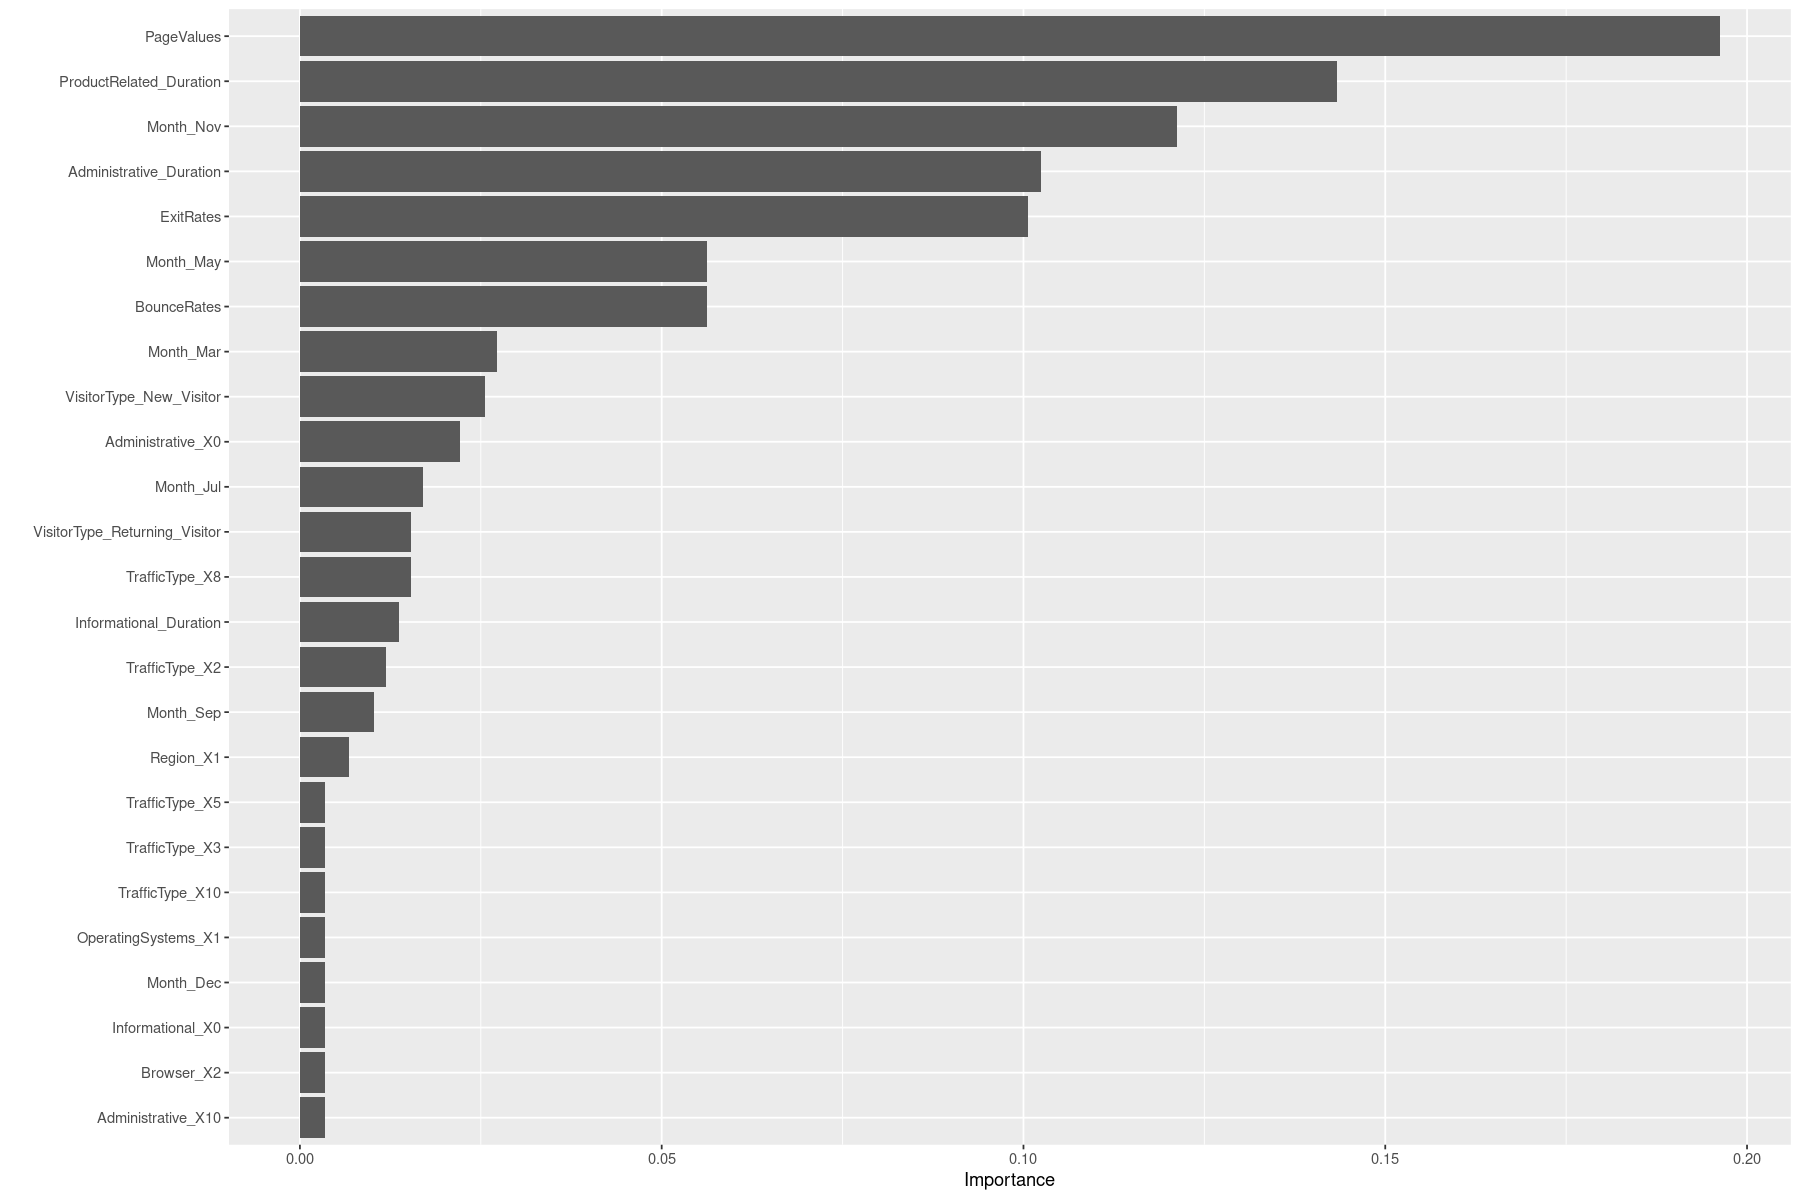

In [31]:
vip::vip(final_model_xgb, type="frequency", num_features = 25)